#Analizador de sentimientos para titulares de noticias (Radio Bío-Bío)

El objetivo de este proyecto es desarrollar un sistema de análisis de sentimientos que califique los titulares de las noticias del portal de la radio Bío-Bío, utilizando herramientas de Procesamiento de Lenguaje Natural (NLP) y ananálisis estadístico para estudiar las tendencias sobre este medio de noticias.  
<br>

![Radio Bío-Bío](https://www.biobiochile.cl/quienes-somos/_nuxt/img/logo-radio.fd1336e.png)

##1) **Dataset**

El dataset utilizado es un archivo .csv proveniente de Kaggle, el cual contiene titulares de noticias scrapeados de la fecha 2023-07-17 hasta el 2023-10-07.

**URL**: https://www.kaggle.com/datasets/sebastiantarebustos/scrapped-chilean-news-articles-from-biobiochile

Al tener variados errores en su creación, se procedió a limpiar manualmente el archivo creando un *.xlsx* nuevo.

**URL**: https://docs.google.com/spreadsheets/d/1sSFThm_qK-XYSCxzmvDVQ26n40lRyfA6/edit?usp=sharing&ouid=110056466329721337592&rtpof=true&sd=true

##2) **Preprocesamiento de Datos**

**a) Limpieza de datos**


In [2]:
# Importar librerías de manipulación de datos

import pandas as pd

In [3]:
# El archivo en su origen contenía muchos errores de su scrapping, por lo que se hizo uno nuevo modificandolo en excel y guardándolo como .xlsx
# Subir archivo .xlsx y leer para conocer su estructura

df = pd.read_excel('/content/biobio_news_v1.xlsx')

df.head()

,article_hash,article_title,category,publish_date,article_body,raw_content,source_entity,article_link,generated_summary,negative_score,importance_score
0,cfca211bf39221671436397b140ea57a7a9268851dfef8...,Solicitan la caducidad de 166 concesiones acuí...,Nacional,2023-07-17 23:54:00,La región de Los Lagos es una de las regiones ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
1,de051d5444e79470f618b38588ea5988ce808ee1db192d...,Lota: Bomberos descarta que auto estacionado e...,Nacional,2023-07-17 23:10:00,Una camioneta se estacionó justo a la salida d...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
2,39dff9b324fe3fb40b70d8a25651e95d57e015ea274865...,Declaran emergencia ambiental para este martes...,Nacional,2023-07-17 23:02:00,La Delegación presidencial declaró emergencia ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
3,f4001720cfe06f5c0aa36c3d8b83bd25a2b8bad50e14c4...,Estudio revela preocupante aumento de tercera ...,Nacional,2023-07-17 21:58:00,Una de las razones de este aumento podría ser ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
4,8212613c7830f1466362f2dfc412c5675cde6376b752df...,"Denuncia de ""malos olores"": Municipalidad de Q...",Nacional,2023-07-17 21:18:00,La Municipalidad de Quilicura reportó la noche...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN


Vemos que el archivo contiene varias features tales como un hash particular, el título de la noticia, categoría, fecha de publicación, cuerpo de la noticia, contenido crudo (html), fuente y url.

Dropearemos columnas innecesarias para quedarnos con los titulos y cuerpos de estos (Para obtener un dataframe y no una serie).



In [4]:
df = df.drop(columns=['article_hash',	'category',	'publish_date',		'raw_content',	'source_entity',	'article_link',	'generated_summary',	'negative_score',	'importance_score'])

In [5]:
print(df)

                                          article_title  \
0     Solicitan la caducidad de 166 concesiones acuí...   
1     Lota: Bomberos descarta que auto estacionado e...   
2     Declaran emergencia ambiental para este martes...   
3     Estudio revela preocupante aumento de tercera ...   
4     Denuncia de "malos olores": Municipalidad de Q...   
...                                                 ...   
5736  EFE reporta problemas en cruces de Línea 2 del...   
5737  Detienen a cuatro sujetos por asesinato de ciu...   
5738  11 detenidos por comercializar autos robados: ...   
5739  Descubren laboratorio clandestino de droga en ...   
5740  "Pa la freedom": indagan a gendarmes por recib...   

                                           article_body  
0     La región de Los Lagos es una de las regiones ...  
1     Una camioneta se estacionó justo a la salida d...  
2     La Delegación presidencial declaró emergencia ...  
3     Una de las razones de este aumento podría ser ...  
4

## 3) **Análisis de sentimientos**:

Se clasificarán los títulos en categorías de sentimiento, como positivo, negativo o neutral. Esto puede hacerse mediante el uso de modelos preentrenados como BERT, que son capaces de comprender el contexto y la semántica del lenguaje natural.

**a) Tokenización**

La tokenización es el proceso de dividir un texto en unidades más pequeñas llamadas tokens. Estos tokens pueden ser palabras individuales, números, signos de puntuación o cualquier otra unidad significativa de texto. La tokenización es una tarea fundamental en el procesamiento del lenguaje natural (NLP)
<br>
<br>
**b) Modelo entrenado**

El modelo preentrenado de BERT de la Universidad de Chile, conocido como 'dccuchile/bert-base-spanish-wwm-cased', está entrenado específicamente en texto en español y utiliza una versión del modelo WordPiece que es sensible a las mayúsculas y minúsculas (cased) y que tiene en cuenta el contexto bidireccional.

In [35]:
# Importar librerías y modelos a utilizar (BERT)

from transformers import BertTokenizer, BertForSequenceClassification
import torch

modelo = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #Modelo entrenado
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #Tokenizador


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

En este proyecto nos enfocaremos en los ***títulos***.

In [37]:
# Tokenizar los títulos

titulares_lista = df['article_title'].tolist()
titulares_tokenizados = tokenizer(titulares_lista, padding=True, truncation=True, return_tensors="pt")

In [38]:
#Revisamos si transformó nuestros títulos a matrices
tokenizer.decode(titulares_tokenizados['input_ids'][0])

'[CLS] solicitan la caducidad de 166 concesiones acuicolas por no operar durante un ano [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

Alimentamos al modelo pre-entrenado con nuestros titulos tokenizados

In [39]:
with torch.no_grad():
    outputs = modelo(**titulares_tokenizados)


## 4) **Interpretación de resultados**

In [40]:
predicciones = torch.argmax(outputs.logits, dim=1).tolist()


In [41]:
print(predicciones)


[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 2, 4, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 3, 3, 1, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 3, 4, 0, 3, 0, 3, 0, 0, 3, 0, 0, 2, 3, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 4, 0, 0, 0, 1, 4, 0, 2, 0, 3, 0, 4, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 4, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 4, 0, 4, 3, 3, 0, 0, 0, 3, 0, 0, 0, 

In [44]:
# Crear un DataFrame con los titulares, puntuaciones y emociones
df_resultado = pd.DataFrame({
    'Título': df['article_title'],
    'Puntuación': predicciones,
    'Emoción': ''
})

# Mapear las puntuaciones a emociones
emociones = {0: 'Muy negativa', 1: 'Negativa', 2: 'Neutral', 3: 'Positiva', 4: 'Muy positiva'}  # Define el mapeo de puntuaciones a emociones

# Asignar emociones basadas en las puntuaciones
df_resultado['Emoción'] = df_resultado['Puntuación'].map(emociones)

df_resultado.head(15)

,Título,Puntuación,Emoción
0,Solicitan la caducidad de 166 concesiones acuí...,0,Muy negativa
1,Lota: Bomberos descarta que auto estacionado e...,0,Muy negativa
2,Declaran emergencia ambiental para este martes...,0,Muy negativa
3,Estudio revela preocupante aumento de tercera ...,0,Muy negativa
4,"Denuncia de ""malos olores"": Municipalidad de Q...",0,Muy negativa
5,La cruzada de autoridades para que región del ...,3,Positiva
6,Se llevaron hasta el hervidor: Capilla Santa T...,0,Muy negativa
7,Delegación de Valparaíso presentará querella p...,0,Muy negativa
8,RN pide a Contraloría que verifique legalidad ...,0,Muy negativa
9,Sofofa suma críticas a la ley de delitos econó...,0,Muy negativa


Se obtuvo un dataframe donde se relaciona la puntuación y emoción asociada con el titular en cuestión. Aunque la mayoría de los títulos son tildados de 'Muy negativos' algunos no corresponden a la emoción que podría evocar en un ser humano.

Esto es debido tal vez al modelo utilizado que se basada en reviews y estrellas de productos, lo cual podría no ser apto para este tipo de inputs.

El objetivo de este proyecto era conocer y utilizar las herramientas NLP para intentar crear un analizador de títulos noticiosos que predijera la emoción del lector. A primera vista es un buen acercamiento ya que algunos títulos positivos son marcados como tal por el modelo. Esto podría mejorar ocupando otros modelos más adecuados especializados en el idioma español o crear un modelo propio pero que llevaría tiempo y recursos.

Algunas estadísticas asociadas:

<ipython-input-51-71a3c5ea5358>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_resultado, x='Emoción', palette='viridis')


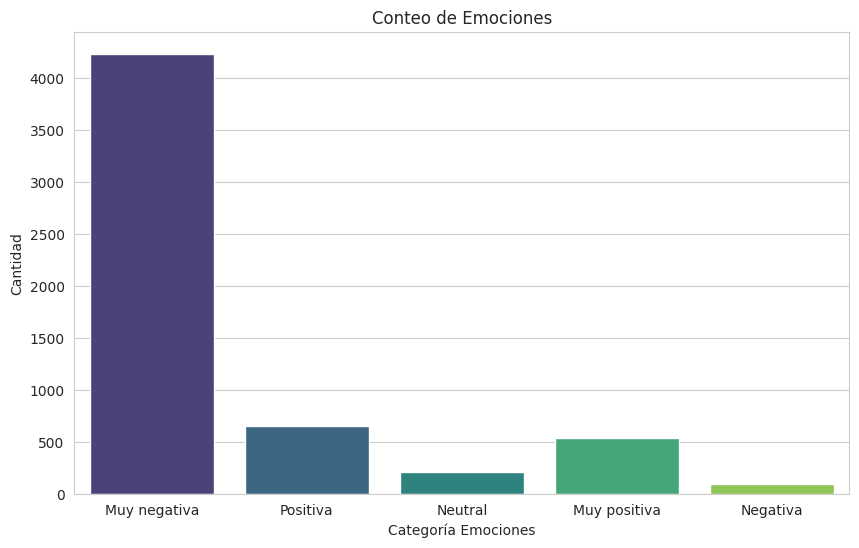

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el estilo de los gráficos
sns.set_style("whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.countplot(data=df_resultado, x='Emoción', palette='viridis')
plt.title('Conteo de Emociones')
plt.xlabel('Categoría Emociones')
plt.ylabel('Cantidad')
plt.show()



In [55]:
conteo_emociones = df_resultado['Emoción'].value_counts()
print(conteo_emociones)


Muy negativa    4229
Positiva         651
Muy positiva     545
Neutral          217
Negativa          99
Name: Emoción, dtype: int64


In [56]:
promedio_puntuaciones = df_resultado['Puntuación'].mean()
print("Promedio de puntuaciones:", promedio_puntuaciones)


Promedio de puntuaciones: 0.8127503919177843


Debido a la gran cantidad de puntuaciones '0' , el promedio esta cerca del 1, lo cual indicaría que la gran mayoría de noticias del portal son 'Muy negativas', según los datos obtenidos.

In [57]:
desviacion_estandar_puntuaciones = df_resultado['Puntuación'].std()
print("Desviación estándar de puntuaciones:", desviacion_estandar_puntuaciones)


Desviación estándar de puntuaciones: 1.4309731266095387


In [59]:
# Calcular el coeficiente de asimetría
import numpy as np

asimetria = np.mean((df_resultado['Puntuación'] - df_resultado['Puntuación'].mean())**3) / (df_resultado['Puntuación'].std()**3)
print("Coeficiente de asimetría:", asimetria)

Coeficiente de asimetría: 1.3405716933647593


Muestra una asimetría positiva, debido a que la cola de distribución se extiende hacía más a la derecha que a la izquierda. Basicamente valores atípicos en el extremo derecho de la distribución.

Ergo, la concentración de datos está más a la izquierda lo que concuerda con la cantidad de emociones negativas predichas por el modelo.